<h3 style="text-align: center;"><b>FashionMNIST</b></h3>

In [0]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import matplotlib.pyplot as plt

%matplotlib inline

Using TensorFlow backend.


In [0]:
input_shape = [None, 28, 28, 1]
number_of_classes = 10

#Hyper parameters
learning_rate = 0.0001
epoch = 30
batch_size = 64

In [0]:
#Loading and splitting data
train_data = pd.read_csv('fashion-mnist_train.csv')
test_data = pd.read_csv('fashion-mnist_test.csv')

print("Training data shape: {}".format(train_data.shape))
print("Test data shape: {}".format(test_data.shape))

Training data shape: (60000, 785)
Test data shape: (10000, 785)


In [0]:
#Features and labeles
train_data_x = train_data.iloc[:, 1:785]
train_data_y = train_data.iloc[:, 0:1]

test_data_x = test_data.iloc[:, 1:785]
test_data_y = test_data.iloc[:, 0:1]

In [0]:
#scalled data
train_data_x = train_data_x/255
test_data_x = test_data_x/255

#Lets convert our training and testing data from pandas dataframes into numpy 
#arrays needed to train our model

train_x = train_data_x.as_matrix()
train_y = train_data_y.as_matrix()

test_x = test_data_x.as_matrix()
test_y = test_data_y.as_matrix()

train_x = train_x.reshape(train_x.shape[0], input_shape[1], 
                          input_shape[2], input_shape[3])
test_x = test_x.reshape(test_x.shape[0], input_shape[1], 
                          input_shape[2], input_shape[3])
#Conver output label to one hot vector
train_y = to_categorical(train_y, 10)
test_y = to_categorical(test_y, 10)


print("Shape of training features: {}".format(train_x.shape))
print("Shape of training lables: {}".format(train_y.shape))
print("Shape of testing features: {}".format(test_x.shape))
print("Shape of testing lables: {}".format(test_y.shape))

Shape of training features: (60000, 28, 28, 1)
Shape of training lables: (60000, 10)
Shape of testing features: (10000, 28, 28, 1)
Shape of testing lables: (10000, 10)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()


In [0]:
#Split the training set into training and cross validation set. We will use the cross validation
#set to check how well our model is doing on unseen training example.

train_x, cv_x, train_y, cv_y = train_test_split(train_x, train_y, 
                                                test_size = 5000, random_state = 42)

print("Number of examples in training set: {}".format(train_x.shape[0]))
print("Number of examples in cross validation set: {}".format(cv_x.shape[0]))

Number of examples in training set: 55000
Number of examples in cross validation set: 5000


In [0]:
def cnn_model_fn(input_shape, number_of_classes, learning_rate):
    input_layer = tf.placeholder(tf.float32, shape=input_shape)
    labels = tf.placeholder(tf.float32, shape=[None, number_of_classes])
    train_mode = tf.placeholder(tf.bool)
    #image ->conv2d->maxpooling->conv2d->maxpooling->flatten->dense->dropout->logits
    #convolution layer 1
    conv1 = tf.layers.conv2d(
        inputs=input_layer, 
        filters=32, 
        kernel_size=[5, 5], 
        padding="same", 
        activation=tf.nn.relu)
    
    #pooling layer 1
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)
    
    #convolution layer 2
    conv2 = tf.layers.conv2d(
        inputs=pool1, 
        filters=64, 
        kernel_size=[5, 5], 
        padding="same", 
        activation=tf.nn.relu)
    
    #pooling layer 1
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)
    
    #flatten the output volume of pool2 into a vector
    pool2_flat = tf.reshape(pool2, shape=[-1, 7*7*64])
    
    #dense layer
    dense = tf.layers.dense(
        inputs=pool2_flat, 
        units=1024,
        activation=tf.nn.relu)
    
    #dropout regularization
    dropout = tf.layers.dropout(
        inputs=dense, 
        rate=0.2, 
        training= train_mode)
    
    #logits layer
    logits = tf.layers.dense(inputs=dropout, units=10)
    
    predictions = {
        "classes" : tf.argmax(input=logits, axis=1),
        "probabilities" : tf.nn.softmax(logits=logits)
    }
    
    #loss
    loss = tf.losses.softmax_cross_entropy(labels, logits)
    
    #training operartion
    train_op = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)
    
    #accuracy
    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(logits, 1), tf.argmax(labels, 1)), tf.float32))
    
    return { "logits": logits,
             "predictions": predictions,
             "loss": loss,
             "train_op": train_op,
             "accuracy": accuracy,
             "x": input_layer,
             "y": labels,
             "train_mode": train_mode }

In [0]:
tf.reset_default_graph()
cnn_model = cnn_model_fn(input_shape, number_of_classes, learning_rate)
x = cnn_model["x"]
y= cnn_model["y"]
train_mode = cnn_model["train_mode"]

In [0]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    #Divide input training set into mini batches of size batch_size.
    #If the total number of training examles is not exactly divisible by batch_size, 
    #the last batch will have less number of examples than batch_size.
    
    total_size = train_x.shape[0]
    number_of_batches = int(total_size/batch_size)
    
    print("Training:Start")
    for e in range(epoch):
        epoch_cost = 0
        epoch_accuracy = 0
        for i in range(number_of_batches):
            mini_x = train_x[i*batch_size:(i+1)*batch_size, :, :, :]
            mini_y = train_y[i*batch_size:(i+1)*batch_size, :]
            _, cost = sess.run([cnn_model["train_op"], cnn_model["loss"]], 
                feed_dict={x:mini_x, 
                           y:mini_y,
                           train_mode:True})
            train_accuracy = sess.run(cnn_model["accuracy"], 
                feed_dict={x:mini_x, 
                           y:mini_y,
                           train_mode:False})
            epoch_cost += cost
            epoch_accuracy += train_accuracy
        
        #If the total number of training examles is not exactly divisible by batch_size, 
        #we have one more batch of size (total_size - number_of_batches*batch_size)
        if total_size % batch_size != 0:
            mini_x = train_x[number_of_batches*batch_size:total_size, :, :, :]
            mini_y = train_y[number_of_batches*batch_size:total_size, :]
            _, cost = sess.run([cnn_model["train_op"], cnn_model["loss"]], 
                feed_dict={x:mini_x, 
                           y:mini_y,
                           train_mode:True})
            train_accuracy = sess.run(cnn_model["accuracy"], 
                feed_dict={x:mini_x, 
                           y:mini_y,
                           train_mode: False})
            epoch_cost += cost
            epoch_accuracy += train_accuracy
        
        epoch_cost /= number_of_batches
        
        if total_size % batch_size != 0:
            epoch_accuracy /= (number_of_batches+1)
        else:
            epoch_accuracy /= number_of_batches
        print("Epoch: {} Cost: {} accuracy: {} ".format(e+1, np.squeeze(epoch_cost), epoch_accuracy))
    
    print("Training:End")
    #Cross validation loss and accuracy
    cv_loss, cv_accuracy = sess.run([cnn_model["loss"], cnn_model["accuracy"]], 
            {x:cv_x, 
             y:cv_y,
             train_mode: False})
    print("Cross validation loss: {} accuracy: {}".format(np.squeeze(cv_loss), cv_accuracy))
    
    #prediction for test set
    test_accuracy, prediction = sess.run([cnn_model["accuracy"], 
                                          cnn_model["predictions"]["classes"]], 
                                         {x:test_x, y:test_y, train_mode:False})
    print("Test set accuracy {}".format(test_accuracy))

Training:Start
Epoch: 1 Cost: 0.6040481159136099 accuracy: 0.7993156492017036 
Epoch: 2 Cost: 0.3964166007545691 accuracy: 0.8652979651162791 
Epoch: 3 Cost: 0.34691150373713103 accuracy: 0.8818737887365874 
Epoch: 4 Cost: 0.3146885647779988 accuracy: 0.8931686046511628 
Epoch: 5 Cost: 0.29208349428715336 accuracy: 0.901538275216901 
Epoch: 6 Cost: 0.27224846058920876 accuracy: 0.9072432170773661 
Epoch: 7 Cost: 0.2568400281896691 accuracy: 0.9148498061784478 
Epoch: 8 Cost: 0.2413274164596731 accuracy: 0.9196281492017037 
Epoch: 9 Cost: 0.22840965935598292 accuracy: 0.92378875966682 
Epoch: 10 Cost: 0.21647575004535866 accuracy: 0.9282764050156571 
Epoch: 11 Cost: 0.20485339645942516 accuracy: 0.932618701527285 
Epoch: 12 Cost: 0.1939003094423636 accuracy: 0.9366521317598432 
Epoch: 13 Cost: 0.1827945342727604 accuracy: 0.9402797965116279 
Epoch: 14 Cost: 0.17387012709300786 accuracy: 0.9443495639534883 
Epoch: 15 Cost: 0.16445950438226198 accuracy: 0.9477289244186047 
Epoch: 16 Cost:

<h3 style="text-align: center;"><b>Style Transfer and CIFAR10</b></h3>

#### Neural Style Transfer:


In [0]:
!pip install tensorflow==1.14.0rc0


  Using cached https://files.pythonhosted.org/packages/6f/0c/355160095d16e6fe06a06474471b4e7560218b152db88a06f0190e7401c9/tensorflow-1.14.0rc0-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/48/6a/7d343697ad80f824f9464e63fb910983174767f099ba6ed2c49cc6873f96/tf_estimator_nightly-1.14.0.dev2019042301-py2.py3-none-any.whl
  Found existing installation: tf-estimator-nightly 1.14.0.dev2019030115
    Uninstalling tf-estimator-nightly-1.14.0.dev2019030115:
      Successfully uninstalled tf-estimator-nightly-1.14.0.dev2019030115
  Found existing installation: tensorflow 2.0.0a0
    Uninstalling tensorflow-2.0.0a0:
      Successfully uninstalled tensorflow-2.0.0a0


# Loading the data

In [0]:
import os
img_dir = '/tmp/nst'
if not os.path.exists(img_dir):
    os.makedirs(img_dir)
!wget --quiet -P /tmp/nst/ https://upload.wikimedia.org/wikipedia/commons/d/d7/Green_Sea_Turtle_grazing_seagrass.jpg
!wget --quiet -P /tmp/nst/ https://upload.wikimedia.org/wikipedia/commons/0/0a/The_Great_Wave_off_Kanagawa.jpg
!wget --quiet -P /tmp/nst/ https://upload.wikimedia.org/wikipedia/commons/b/b4/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg
!wget --quiet -P /tmp/nst/ https://upload.wikimedia.org/wikipedia/commons/0/00/Tuebingen_Neckarfront.jpg
!wget --quiet -P /tmp/nst/ https://upload.wikimedia.org/wikipedia/commons/6/68/Pillars_of_creation_2014_HST_WFC3-UVIS_full-res_denoised.jpg
!wget --quiet -P /tmp/nst/ https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/1024px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg

# Download and configure the module

In [0]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10,10)
mpl.rcParams['axes.grid'] = False

import numpy as np
from PIL import Image
import time
import functools

In [0]:
import tensorflow as tf
import tensorflow.contrib.eager as tfe

from tensorflow.python.keras.preprocessing import image as kp_image
from tensorflow.python.keras import models 
from tensorflow.python.keras import losses
from tensorflow.python.keras import layers
from tensorflow.python.keras import backend as K

In [0]:
tf.enable_eager_execution()
print("Eager execution: {}".format(tf.executing_eagerly()))

Eager execution: True


In [0]:
# Set up some global values here
content_path = '/tmp/nst/Green_Sea_Turtle_grazing_seagrass.jpg'
style_path = '/tmp/nst/The_Great_Wave_off_Kanagawa.jpg'

# Visualization input data

In [0]:
def load_img(path_to_img):
  max_dim = 512
  img = Image.open(path_to_img)
  long = max(img.size)
  scale = max_dim/long
  img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), Image.ANTIALIAS)
  
  img = kp_image.img_to_array(img)
  
  # We need to broadcast the image array such that it has a batch dimension 
  img = np.expand_dims(img, axis=0)
  return img

In [0]:
def imshow(img, title=None):
  # Remove the batch dimension
  out = np.squeeze(img, axis=0)
  # Normalize for display 
  out = out.astype('uint8')
  plt.imshow(out)
  if title is not None:
    plt.title(title)
  plt.imshow(out)

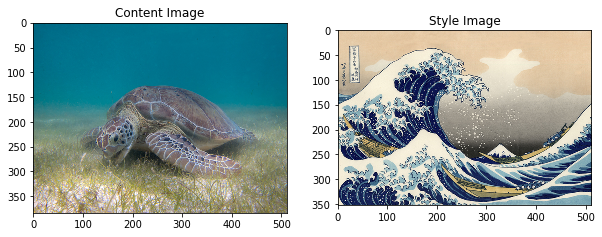

In [0]:
plt.figure(figsize=(10,10))

content = load_img(content_path).astype('uint8')
style = load_img(style_path).astype('uint8')

plt.subplot(1, 2, 1)
imshow(content, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style, 'Style Image')
plt.show()

# Data preparation

In [0]:
def load_and_process_img(path_to_img):
  img = load_img(path_to_img)
  img = tf.keras.applications.vgg19.preprocess_input(img)
  return img

In [0]:
def deprocess_img(processed_img):
  x = processed_img.copy()
  if len(x.shape) == 4:
    x = np.squeeze(x, 0)
  assert len(x.shape) == 3, ("Input to deprocess image must be an image of "
                             "dimension [1, height, width, channel] or [height, width, channel]")
  if len(x.shape) != 3:
    raise ValueError("Invalid input to deprocessing image")
  
  # perform the inverse of the preprocessiing step
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1]

  x = np.clip(x, 0, 255).astype('uint8')
  return x

# Define the presentation style

In [0]:
# Content layer where will pull our feature maps
content_layers = ['block5_conv2'] 

# Style layer we are interested in
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1'
               ]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

# Model building

In [0]:
def get_model():
  """ Creates our model with access to intermediate layers. 
  
  This function will load the VGG19 model and access the intermediate layers. 
  These layers will then be used to create a new model that will take input image
  and return the outputs from these intermediate layers from the VGG model. 
  
  Returns:
    returns a keras model that takes image inputs and outputs the style and 
      content intermediate layers. 
  """
  # Load our model. We load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  # Get output layers corresponding to style and content layers 
  style_outputs = [vgg.get_layer(name).output for name in style_layers]
  content_outputs = [vgg.get_layer(name).output for name in content_layers]
  model_outputs = style_outputs + content_outputs
  # Build model 
  return models.Model(vgg.input, model_outputs)

# Define and create a loss-function


In [0]:
def get_content_loss(base_content, target):
  return tf.reduce_mean(tf.square(base_content - target))

# Consider style loss


In [0]:
def gram_matrix(input_tensor):
  # We make the image channels first 
  channels = int(input_tensor.shape[-1])
  a = tf.reshape(input_tensor, [-1, channels])
  n = tf.shape(a)[0]
  gram = tf.matmul(a, a, transpose_a=True)
  return gram / tf.cast(n, tf.float32)

def get_style_loss(base_style, gram_target):
  """Expects two images of dimension h, w, c"""
  # height, width, num filters of each layer
  # We scale the loss at a given layer by the size of the feature map and the number of filters
  height, width, channels = base_style.get_shape().as_list()
  gram_style = gram_matrix(base_style)
  
  return tf.reduce_mean(tf.square(gram_style - gram_target))# / (4. * (channels ** 2) * (width * height) ** 2)

# Apply style transfer to images


In [0]:
def get_feature_representations(model, content_path, style_path):
  """Helper function to compute our content and style feature representations.

  This function will simply load and preprocess both the content and style 
  images from their path. Then it will feed them through the network to obtain
  the outputs of the intermediate layers. 
  
  Arguments:
    model: The model that we are using.
    content_path: The path to the content image.
    style_path: The path to the style image
    
  Returns:
    returns the style features and the content features. 
  """
  # Load our images in 
  content_image = load_and_process_img(content_path)
  style_image = load_and_process_img(style_path)
  
  # batch compute content and style features
  style_outputs = model(style_image)
  content_outputs = model(content_image)
  
  
  # Get the style and content feature representations from our model  
  style_features = [style_layer[0] for style_layer in style_outputs[:num_style_layers]]
  content_features = [content_layer[0] for content_layer in content_outputs[num_style_layers:]]
  return style_features, content_features

# Calculating losses and gradients


In [0]:
def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
  """This function will compute the loss total loss.
  
  Arguments:
    model: The model that will give us access to the intermediate layers
    loss_weights: The weights of each contribution of each loss function. 
      (style weight, content weight, and total variation weight)
    init_image: Our initial base image. This image is what we are updating with 
      our optimization process. We apply the gradients wrt the loss we are 
      calculating to this image.
    gram_style_features: Precomputed gram matrices corresponding to the 
      defined style layers of interest.
    content_features: Precomputed outputs from defined content layers of 
      interest.
      
  Returns:
    returns the total loss, style loss, content loss, and total variational loss
  """
  style_weight, content_weight = loss_weights
  
  # Feed our init image through our model. This will give us the content and 
  # style representations at our desired layers. Since we're using eager
  # our model is callable just like any other function!
  model_outputs = model(init_image)
  
  style_output_features = model_outputs[:num_style_layers]
  content_output_features = model_outputs[num_style_layers:]
  
  style_score = 0
  content_score = 0

  # Accumulate style losses from all layers
  # Here, we equally weight each contribution of each loss layer
  weight_per_style_layer = 1.0 / float(num_style_layers)
  for target_style, comb_style in zip(gram_style_features, style_output_features):
    style_score += weight_per_style_layer * get_style_loss(comb_style[0], target_style)
    
  # Accumulate content losses from all layers 
  weight_per_content_layer = 1.0 / float(num_content_layers)
  for target_content, comb_content in zip(content_features, content_output_features):
    content_score += weight_per_content_layer* get_content_loss(comb_content[0], target_content)
  
  style_score *= style_weight
  content_score *= content_weight

  # Get total loss
  loss = style_score + content_score 
  return loss, style_score, content_score

In [0]:
def compute_grads(cfg):
  with tf.GradientTape() as tape: 
    all_loss = compute_loss(**cfg)
  # Compute gradients wrt input image
  total_loss = all_loss[0]
  return tape.gradient(total_loss, cfg['init_image']), all_loss

# Optimization cycle

In [0]:
import IPython.display

def run_style_transfer(content_path, 
                       style_path,
                       num_iterations=1000,
                       content_weight=1e3, 
                       style_weight=1e-2): 
  # We don't need to (or want to) train any layers of our model, so we set their
  # trainable to false. 
  model = get_model() 
  for layer in model.layers:
    layer.trainable = False
  
  # Get the style and content feature representations (from our specified intermediate layers) 
  style_features, content_features = get_feature_representations(model, content_path, style_path)
  gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]
  
  # Set initial image
  init_image = load_and_process_img(content_path)
  init_image = tfe.Variable(init_image, dtype=tf.float32)
  # Create our optimizer
  opt = tf.train.AdamOptimizer(learning_rate=5, beta1=0.99, epsilon=1e-1)

  # For displaying intermediate images 
  iter_count = 1
  
  # Store our best result
  best_loss, best_img = float('inf'), None
  
  # Create a nice config 
  loss_weights = (style_weight, content_weight)
  cfg = {
      'model': model,
      'loss_weights': loss_weights,
      'init_image': init_image,
      'gram_style_features': gram_style_features,
      'content_features': content_features
  }
    
  # For displaying
  num_rows = 2
  num_cols = 5
  display_interval = num_iterations/(num_rows*num_cols)
  start_time = time.time()
  global_start = time.time()
  
  norm_means = np.array([103.939, 116.779, 123.68])
  min_vals = -norm_means
  max_vals = 255 - norm_means   
  
  imgs = []
  for i in range(num_iterations):
    grads, all_loss = compute_grads(cfg)
    loss, style_score, content_score = all_loss
    opt.apply_gradients([(grads, init_image)])
    clipped = tf.clip_by_value(init_image, min_vals, max_vals)
    init_image.assign(clipped)
    end_time = time.time() 
    
    if loss < best_loss:
      # Update best loss and best image from total loss. 
      best_loss = loss
      best_img = deprocess_img(init_image.numpy())

    if i % display_interval== 0:
      start_time = time.time()
      
      # Use the .numpy() method to get the concrete numpy array
      plot_img = init_image.numpy()
      plot_img = deprocess_img(plot_img)
      imgs.append(plot_img)
      IPython.display.clear_output(wait=True)
      IPython.display.display_png(Image.fromarray(plot_img))
      print('Iteration: {}'.format(i))        
      print('Total loss: {:.4e}, ' 
            'style loss: {:.4e}, '
            'content loss: {:.4e}, '
            'time: {:.4f}s'.format(loss, style_score, content_score, time.time() - start_time))
  print('Total time: {:.4f}s'.format(time.time() - global_start))
  IPython.display.clear_output(wait=True)
  plt.figure(figsize=(14,4))
  for i,img in enumerate(imgs):
      plt.subplot(num_rows,num_cols,i+1)
      plt.imshow(img)
      plt.xticks([])
      plt.yticks([])
      
  return best_img, best_loss

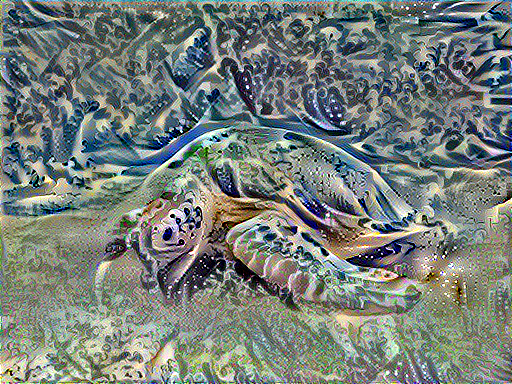

Iteration: 300
Total loss: 4.4332e+06, style loss: 3.2333e+06, content loss: 1.1999e+06, time: 0.0756s


KeyboardInterrupt: ignored

In [0]:
best, best_loss = run_style_transfer(content_path, style_path, num_iterations=1000)

In [0]:
#from google.colab import files
#files.download('wave_turtle.png')

# Visualize the resulting style transfer


In [0]:
def show_results(best_img, content_path, style_path, show_large_final=True):
  plt.figure(figsize=(10, 5))
  content = load_img(content_path) 
  style = load_img(style_path)

  plt.subplot(1, 2, 1)
  imshow(content, 'Content Image')

  plt.subplot(1, 2, 2)
  imshow(style, 'Style Image')

  if show_large_final: 
    plt.figure(figsize=(10, 10))

    plt.imshow(best_img)
    plt.title('Output Image')
    plt.show()

# Examples

In [0]:
best_kandinsky_tubingen, best_loss = run_style_transfer('/tmp/nst/Tuebingen_Neckarfront.jpg', 
                                                  '/tmp/nst/Vassily_Kandinsky,_1913_-_Composition_7.jpg', num_iterations = 200)

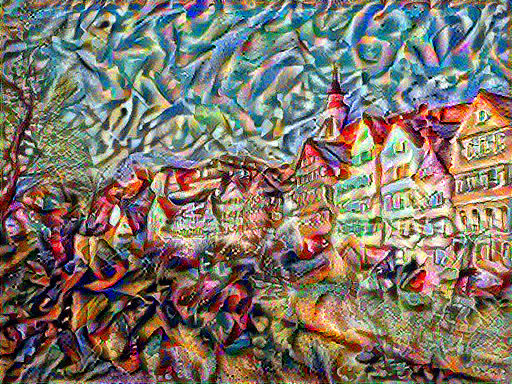

In [0]:
Image.fromarray(best_kandinsky_tubingen)

In [0]:
def show_results(best_img, content_path, style_path, show_large_final=True):
  plt.figure(figsize=(10, 5))
  content = load_img(content_path) 
  style = load_img(style_path)

  plt.subplot(1, 2, 1)
  imshow(content, 'Content Image')

  plt.subplot(1, 2, 2)
  imshow(style, 'Style Image')

  if show_large_final: 
    plt.figure(figsize=(10, 10))

    plt.imshow(best_img)
    plt.title('Output Image')
    plt.show()

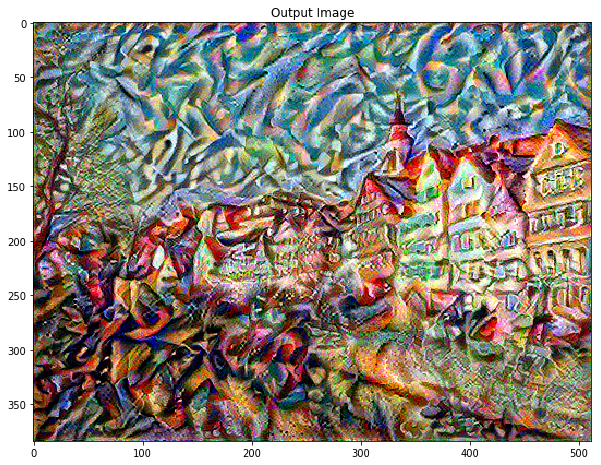

In [0]:
show_results(best_kandinsky_tubingen, '/tmp/nst/Tuebingen_Neckarfront.jpg', '/tmp/nst/Vassily_Kandinsky,_1913_-_Composition_7.jpg')

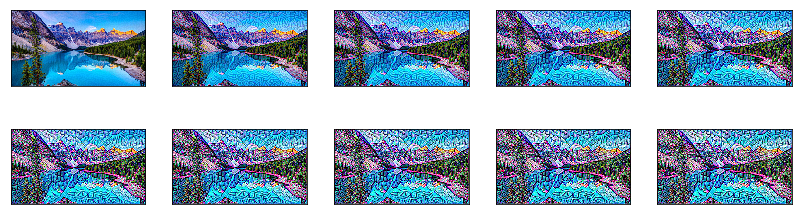

In [0]:
best_f1_f2, best_loss = run_style_transfer('Фото на стиль.jpg', 
                                                  'Фото стиля.jpg', num_iterations = 100)

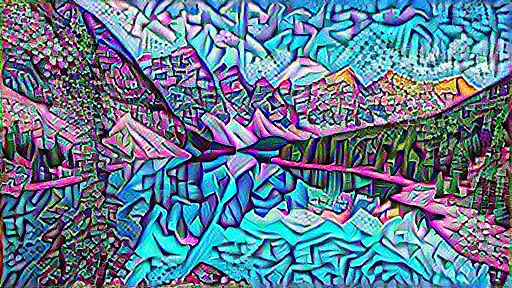

In [0]:
Image.fromarray(best_f1_f2)

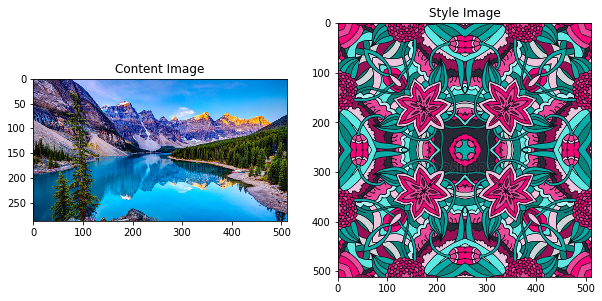

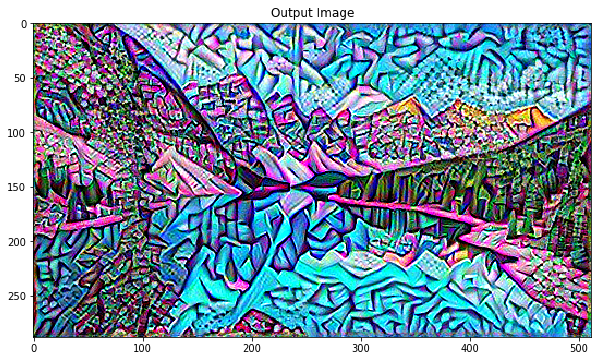

In [0]:
show_results(best_f1_f2, 'Фото на стиль.jpg', 'Фото стиля.jpg')

#### CIFAR10:

In [0]:
cifar10_dir= 'cifar-10-batches-py'

In [0]:
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


# Check the data

In [0]:
# Setting up the environment
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle

In [0]:
# Function to load a batch into memory
def load_batch(data_dir, batch_id):
    with open(os.path.join(cifar10_dir, 'data_batch_%i' % batch_id), mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')
    feats = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    lbls = batch['labels']
    return feats, lbls

In [0]:
# and load the first batch
feats, labels = load_batch(cifar10_dir, 1)

In [0]:
sample_id = 17
sample_img = feats[sample_id]
sample_lbl = labels[sample_id]
print('Label Id: {} - Class: {}'.format(sample_lbl, label_names[sample_lbl]))
plt.imshow(sample_img)

In [0]:
# some stats
print([sample_img.min(), sample_img.max(), sample_img.shape])

# Preprocessing 

Normalized the data

In [0]:
def normalize(x):
    return x / 255.

One-hot encoding

In [0]:
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer().fit(range(10))

def one_hot_encode(x):
    global lb
    return lb.transform(x)

# Split into training and test data

In [0]:
test_feats, test_lbls = [], []

In [0]:
for i in range(1, 6):
    feats, lbls = load_batch(cifar10_dir, i)
    test_size = int(len(feats) * 0.1)
    
    # training data
    norm_feats = normalize(feats[:-test_size])
    one_hot_lbls = one_hot_encode(lbls[:-test_size])
    pickle.dump((norm_feats, one_hot_lbls), open('preprocess_batch_%i.p' % i, 'wb'))
    
    # add the rest to the test data
    test_feats.extend(feats[-test_size:])
    test_lbls.extend(lbls[-test_size:])

# dump the test data too
norm_test_feats = normalize(np.array(test_feats))
one_hot_test_lbls = one_hot_encode(np.array(test_lbls))
pickle.dump((norm_test_feats, one_hot_test_lbls), open('preprocess_test.p', 'wb'))

# Build the network

In [0]:
import tensorflow as tf


In [0]:
def conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides):
    """
    Apply convolution then max pooling to x_tensor
    :param x_tensor: TensorFlow Tensor
    :param conv_num_outputs: Number of outputs for the convolutional layer
    :param conv_ksize: kernal size 2-D Tuple for the convolutional layer
    :param conv_strides: Stride 2-D Tuple for convolution
    :param pool_ksize: kernal size 2-D Tuple for pool
    :param pool_strides: Stride 2-D Tuple for pool
    : return: A tensor that represents convolution and max pooling of x_tensor
    """
    # Weights
    W_shape = list(conv_ksize) + [int(x_tensor.shape[3]), conv_num_outputs]
    W = tf.Variable(tf.truncated_normal(W_shape, stddev=.05))
    
    # Apply convolution
    x = tf.nn.conv2d(
        x_tensor, W,
        strides = [1] + list(conv_strides) + [1],
        padding = 'SAME'
    )
    
    # Add bias
    b = tf.Variable(tf.zeros([conv_num_outputs]))
    x = tf.nn.bias_add(x, b)
    
    # Nonlinear activation (ReLU)
    x = tf.nn.relu(x)
    
    # Max pooling
    return tf.nn.max_pool(
        x,
        ksize = [1] + list(pool_ksize) + [1],
        strides = [1] + list(pool_strides) + [1],
        padding = 'SAME'
    )

In [0]:
def flatten(x_tensor):
    """
    Flatten x_tensor to (Batch Size, Flattened Image Size)
    : x_tensor: A tensor of size (Batch Size, ...), where ... are the image dimensions.
    : return: A tensor of size (Batch Size, Flattened Image Size).
    """
    return tf.reshape(x_tensor, [-1, np.prod(x_tensor.shape.as_list()[1:])])

In [0]:
def fully_conn(x_tensor, num_outputs):
    """
    Apply a fully connected layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    # Weights and bias
    W = tf.Variable(tf.truncated_normal([int(x_tensor.shape[1]), num_outputs], stddev=.05))
    b = tf.Variable(tf.zeros([num_outputs]))
    
    # The fully connected layer
    x = tf.add(tf.matmul(x_tensor, W), b)
    
    # ReLU activation function
    return tf.nn.relu(x)

In [0]:
def output(x_tensor, num_outputs):
    """
    Apply a output layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    # Weights and bias
    W = tf.Variable(tf.truncated_normal([int(x_tensor.shape[1]), num_outputs], stddev=.05))
    b = tf.Variable(tf.zeros([num_outputs]))
    
    # The output layer
    return tf.add(tf.matmul(x_tensor, W), b)

In [0]:
def conv_net(x, keep_prob):
    """
    Create a convolutional neural network model
    : x: Placeholder tensor that holds image data.
    : keep_prob: Placeholder tensor that hold dropout keep probability.
    : return: Tensor that represents logits
    """
    # 3 convolution layers with max pooling
    # All layers with same kernel, stride and maxpooling params
    x = conv2d_maxpool(x, 64, (3,3), (1,1), (2,2), (2,2))
    x = conv2d_maxpool(x, 128, (3,3), (1,1), (2,2), (2,2))
    x = conv2d_maxpool(x, 256, (3,3), (1,1), (2,2), (2,2))
    
    # dropout after convolutions
    x = tf.nn.dropout(x, keep_prob)
    
    # flatten layer
    x = flatten(x)

    # 1 fully connected layer followed by dropout
    x = fully_conn(x, 1024)
    x = tf.nn.dropout(x, keep_prob)
    
    # output layer
    return output(x, 10)

In [0]:
# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

# Inputs
x = tf.placeholder(tf.float32, [None, 32, 32, 3], name="x")
y = tf.placeholder(tf.float32, [None, 10], name="y")
keep_prob = tf.placeholder(tf.float32, name="keep_prob")

# Model
logits = conv_net(x, keep_prob)

# Name logits Tensor, so that is can be loaded from disk after training
logits = tf.identity(logits, name='logits')

# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer().minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

# Prepare a function that yields loss and validation accuracy during training and validation:

In [0]:
def print_stats(session, feature_batch, label_batch, cost, accuracy):
    """
    Print information about loss and validation accuracy
    : session: Current TensorFlow session
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    : cost: TensorFlow cost function
    : accuracy: TensorFlow accuracy function
    """
    global valid_features, valid_labels
    loss = sess.run(cost, feed_dict={x: feature_batch, y: label_batch, keep_prob: 1.})
    valid_acc = sess.run(
        accuracy, 
        feed_dict={
            x: norm_test_feats,
            y: one_hot_test_lbls,
            keep_prob: 1.
        }
    )
    print('Loss: {:>8.4f}, Validation Accuracy: {:>8.6f}'.format(loss, valid_acc))

# Hyperparameters

In [0]:
epochs = 80
batch_size = 1024
keep_probability = 0.5

# Functions for loading the preprocessed training data:

In [0]:
def batch_features_labels(features, labels, batch_size):
    """
    Split features and labels into batches
    """
    for start in range(0, len(features), batch_size):
        end = min(start + batch_size, len(features))
        yield features[start:end], labels[start:end]


def load_preprocess_training_batch(batch_id, batch_size):
    """
    Load the Preprocessed Training data and return them in batches of <batch_size> or less
    """
    filename = 'preprocess_batch_' + str(batch_id) + '.p'
    features, labels = pickle.load(open(filename, mode='rb'))

    # Return the training data in batches of size <batch_size> or less
    return batch_features_labels(features, labels, batch_size)

# Train the model

In [0]:
print("Training...")
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        n_batches = 5
        for batch_i in range(1, n_batches+1):
            for batch_features, batch_labels in load_preprocess_training_batch(batch_i, batch_size):
                sess.run(
                    optimizer, 
                    feed_dict={
                        x: batch_features, 
                        y: batch_labels, 
                        keep_prob: keep_probability
                    }
                )
            print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
            print_stats(sess, batch_features, batch_labels, cost, accuracy)
    
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, './image_classification')

# Test the model

In [0]:
import tensorflow as tf
import pickle
import random
import numpy as np

In [0]:
model_path = './image_classification'
n_samples = 4
top_n_predictions = 3

In [0]:
test_features, test_labels = pickle.load(open('preprocess_test.p', mode='rb'))
loaded_graph = tf.Graph()

In [0]:
def batch_features_labels(features, labels, batch_size):
    """
    Split features and labels into batches
    """
    for start in range(0, len(features), batch_size):
        end = min(start + batch_size, len(features))
        yield features[start:end], labels[start:end]


In [0]:
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt

def display_image_predictions(features, labels, predictions):
    n_classes = 10
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(range(n_classes))
    label_ids = label_binarizer.inverse_transform(np.array(labels))

    fig, axies = plt.subplots(nrows=4, ncols=2)
    fig.tight_layout()
    fig.suptitle('Softmax Predictions', fontsize=20, y=1.1)

    n_predictions = 3
    margin = 0.05
    ind = np.arange(n_predictions)
    width = (1. - 2. * margin) / n_predictions

    for image_i, (feature, label_id, pred_indicies, pred_values) in enumerate(zip(features, label_ids, predictions.indices, predictions.values)):
        pred_names = [label_names[pred_i] for pred_i in pred_indicies]
        correct_name = label_names[label_id]

        axies[image_i][0].imshow(feature)
        axies[image_i][0].set_title(correct_name)
        axies[image_i][0].set_axis_off()

        axies[image_i][1].barh(ind + margin, pred_values[::-1], width)
        axies[image_i][1].set_yticks(ind + margin)
        axies[image_i][1].set_yticklabels(pred_names[::-1])
        axies[image_i][1].set_xticks([0, 0.5, 1.0])

In [0]:
with tf.Session(graph=loaded_graph) as sess:
    # Load model
    loader = tf.train.import_meta_graph(model_path + '.meta')
    loader.restore(sess, model_path)

    # Get Tensors from loaded model
    loaded_x = loaded_graph.get_tensor_by_name('x:0')
    loaded_y = loaded_graph.get_tensor_by_name('y:0')
    loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
    loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
    loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
    # Get accuracy in batches for memory limitations
    test_batch_acc_total = 0
    test_batch_count = 0
    
    for test_feature_batch, test_label_batch in batch_features_labels(test_features, test_labels, batch_size):
        test_batch_acc_total += sess.run(
            loaded_acc,
            feed_dict={
                loaded_x: test_feature_batch, 
                loaded_y: test_label_batch, 
                loaded_keep_prob: 1.0
            }
        )
        test_batch_count += 1

    print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

    # Print Random Samples
    random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
    random_test_predictions = sess.run(
        tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
        feed_dict={
            loaded_x: random_test_features, 
            loaded_y: random_test_labels, 
            loaded_keep_prob: 1.0
        }
    )
    display_image_predictions(random_test_features, random_test_labels, random_test_predictions)